In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wav2clip

In [83]:
def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.6149238749575318


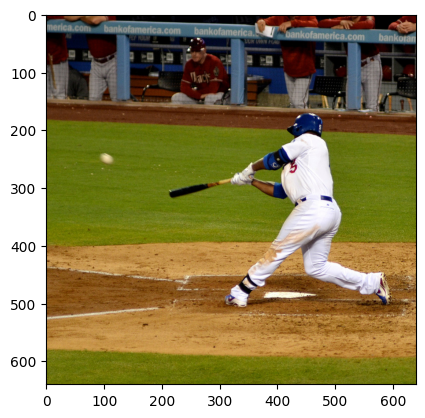

In [84]:
import IPython.display as ipd

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/music/' + music_id + '.wav'
    image_path = 'data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [87]:
from torch.utils.data import Dataset, DataLoader
import audio2numpy as a2n
import wav2clip as w2c
import cv2
from tqdm import tqdm

IMAGE_PATH = 'data/images/'
MUSIC_PATH = 'data/music/'
IMAGE_SIZE = 64

class MusicImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.w2c_model = w2c.get_model() 
        self._load()

    def _load(self):
        self.data = []
        pbar = tqdm(self.dataframe.iterrows(), total=len(self.dataframe), desc='Loading data')
        for _, row in pbar:
            music_id = row['music_id']
            image_id = row['image_id']
            music_path = MUSIC_PATH + music_id + '.wav'
            image_path = IMAGE_PATH + image_id + '.jpg'
            try:
                audio_embedding = self._read_audio(music_path)
                image = self._read_img(image_path)
                self.data.append((audio_embedding, image))
            except Exception as e:
                print(e)
                print(f'Image: {image_path}')
                print(f'Audio: {music_path}')

    def _read_img(self, image_path):
        image = cv2.imread(image_path)
        resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        return cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).reshape(3, IMAGE_SIZE, IMAGE_SIZE)

    def _read_audio(self, audio_path):
        audio, sr = a2n.audio_from_file(audio_path)
        audio_embedding = w2c.embed_audio(audio, self.w2c_model)
        audio_embedding = np.squeeze(audio_embedding)
        return audio_embedding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [88]:
BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

Loading data: 100%|██████████| 7249/7249 [13:15<00:00,  9.12it/s]


In [126]:

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)

In [128]:
class Music2ImageGenerator(nn.Module):
    def __init__(self, z_dim=512, embed_size=512, channels=3, conv_dim=64):
        super().__init__()
        self.l1 = conv_block(z_dim + embed_size, conv_dim * 8, pad=0, transpose=True)
        self.l2 = conv_block(conv_dim * 8, conv_dim * 4, transpose=True)
        self.l3 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.l4 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.l5 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, music):
        x = torch.cat([x, music], dim=1).reshape(x.shape[0], -1, 1, 1)
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = torch.tanh(self.l5(x))
        return x


class FakeImageDiscriminator(nn.Module):
    def __init__(self, channels=3, conv_dim=64):
        super().__init__()
        self.l1 = conv_block(channels, conv_dim, use_bn=False)
        self.l2 = conv_block(conv_dim, conv_dim * 2)
        self.l3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.l4 = conv_block(conv_dim * 4, conv_dim * 8)
        self.l5 = conv_block(conv_dim * 8, conv_dim * 8, k_size=4, stride=1, pad=0, use_bn=False)
        self.fc = nn.Linear(512, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        x = x.squeeze()
        x = self.fc(x)
        return F.sigmoid(x)

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

generator = Music2ImageGenerator().to(device)
discriminator = FakeImageDiscriminator().to(device)

In [130]:
for music, image in val_loader:
    music = music.to(device)
    image = image.to(device)
    print(music.size(), image.size())
    z = torch.randn(music.size(0), 512).to(device)
    fake_image = generator(z, music)
    print(fake_image.size())
    out = discriminator(fake_image)
    print(out)
    break

torch.Size([32, 512]) torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
tensor([[0.3004],
        [0.6694],
        [0.7168],
        [0.3928],
        [0.5605],
        [0.5304],
        [0.4515],
        [0.3573],
        [0.4170],
        [0.2090],
        [0.5603],
        [0.3916],
        [0.3361],
        [0.4793],
        [0.4855],
        [0.2935],
        [0.5768],
        [0.2554],
        [0.5630],
        [0.3779],
        [0.3898],
        [0.2754],
        [0.2148],
        [0.3952],
        [0.4623],
        [0.3941],
        [0.1742],
        [0.3793],
        [0.1559],
        [0.3816],
        [0.3038],
        [0.5656]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [131]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
criterion = nn.BCELoss()

real_label = torch.FloatTensor(BATCH_SIZE).uniform_(0.9, 1).to(device).reshape(-1, 1)
fake_label = torch.FloatTensor(BATCH_SIZE).uniform_(0, 0.1).to(device).reshape(-1, 1)

In [132]:
def train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion):
    generator.train()
    discriminator.train()
    pbar = tqdm(train_loader)

    G_losses = []
    D_losses = []

    D_accuracies = []

    for music, image in pbar:

        music = music.to(device)
        image = image.to(device).to(torch.float32) # !!!!!!!

        # Train discriminator on real images
        optimizer_D.zero_grad()
        D_real_output = discriminator(image)
        D_real_loss = criterion(D_real_output, real_label)

        # Train discriminator on fake images
        noise = torch.randn(music.size(0), 512).to(device) # dim - image dimension
        fake_images = generator(noise, music)
        D_fake_output = discriminator(fake_images.detach()) # detach to avoid training generator
        D_fake_loss = criterion(D_fake_output, fake_label)
        
        discriminator_loss = D_real_loss + D_fake_loss
        D_losses.append(discriminator_loss.item())

        D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)  
        D_accuracies.append(D_accuracy)

        discriminator_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        D_fake_output = discriminator(fake_images)
        G_loss = criterion(D_fake_output, real_label)
        G_losses.append(G_loss.item())

        G_loss.backward()
        optimizer_G.step()

        pbar.set_description(f'Epoch {epoch}, Generator Loss: {np.mean(G_losses):.5f}, Discriminator Loss: {np.mean(D_losses):.5f}, Discriminator Accuracy: {np.mean(D_accuracies):.5f}')

In [133]:
def evaluate(epoch, val_loader, generator, discriminator, criterion):
    generator.eval()
    discriminator.eval()

    G_losses = []
    D_losses = []

    D_accuracies = []

    pbar = tqdm(val_loader)
    with torch.no_grad():
        for music, image in pbar:

            music = music.to(device)
            image = image.to(device).to(torch.float32) # !!!!!!!

            # Evaluate discriminator on real images
            D_real_output = discriminator(image)
            D_real_loss = criterion(D_real_output, real_label)

            # Evaluate discriminator on fake images
            noise = torch.randn(music.size(0), 512).to(device)
            fake_images = generator(noise, music)
            D_fake_output = discriminator(fake_images.detach())

            D_fake_loss = criterion(D_fake_output, fake_label)

            discriminator_loss = D_real_loss + D_fake_loss
            D_losses.append(discriminator_loss.item())

            D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)
            D_accuracies.append(D_accuracy)

            # Evaluate generator
            D_fake_output = discriminator(fake_images)
            G_loss = criterion(D_fake_output, real_label)
            G_losses.append(G_loss.item())

            pbar.set_description(f'\tValidation Epoch {epoch}, Generator Loss: {np.mean(G_losses):.5f}, Discriminator Loss: {np.mean(D_losses):.5f}, Discriminator Accuracy: {np.mean(D_accuracies):.5f}')

    return np.mean(G_losses), np.mean(D_losses)

In [154]:
EPOCHS = 10
best_val_score = 1e9, 1e9

for epoch in range(EPOCHS):
    train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion)
    val_score = evaluate(epoch, val_loader, generator, discriminator, criterion)
    if val_score < best_val_score:
        best_val_score = val_score
        torch.save(generator.state_dict(), 'models/best_generator.pth')
        torch.save(discriminator.state_dict(), 'models/best_discriminator.pth')

Epoch 0, Generator Loss: 2.88126, Discriminator Loss: 0.39210, Discriminator Accuracy: 1.00000: 100%|██████████| 928/928 [01:04<00:00, 14.28it/s]
	Validation Epoch 0, Generator Loss: 0.42421, Discriminator Loss: 1.34826, Discriminator Accuracy: 1.00000: 100%|██████████| 71/71 [00:01<00:00, 39.83it/s]
Epoch 1, Generator Loss: 2.87938, Discriminator Loss: 0.39194, Discriminator Accuracy: 1.00000: 100%|██████████| 928/928 [01:05<00:00, 14.15it/s]
	Validation Epoch 1, Generator Loss: 0.35313, Discriminator Loss: 1.54241, Discriminator Accuracy: 1.00000: 100%|██████████| 71/71 [00:01<00:00, 39.24it/s]
Epoch 2, Generator Loss: 2.88017, Discriminator Loss: 0.39193, Discriminator Accuracy: 1.00000: 100%|██████████| 928/928 [01:06<00:00, 14.05it/s]
	Validation Epoch 2, Generator Loss: 0.47602, Discriminator Loss: 1.38032, Discriminator Accuracy: 1.00000: 100%|██████████| 71/71 [00:01<00:00, 38.95it/s]
Epoch 3, Generator Loss: 2.88551, Discriminator Loss: 0.39215, Discriminator Accuracy: 1.00000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


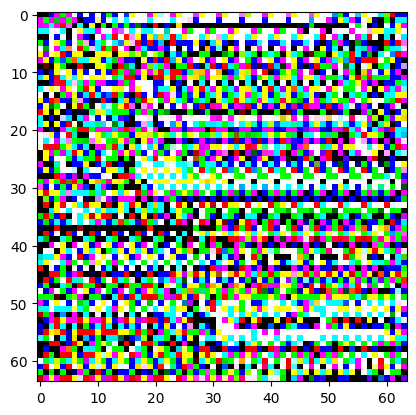

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


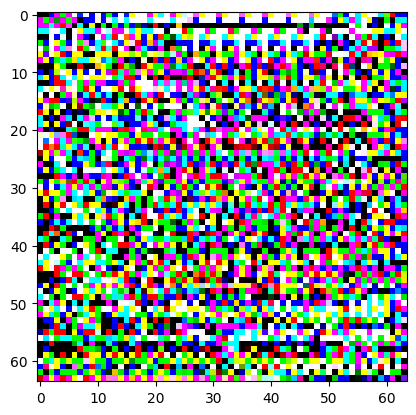

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


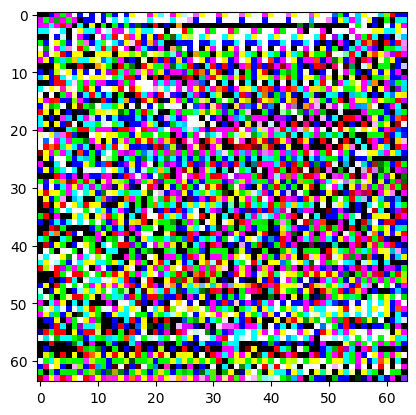

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


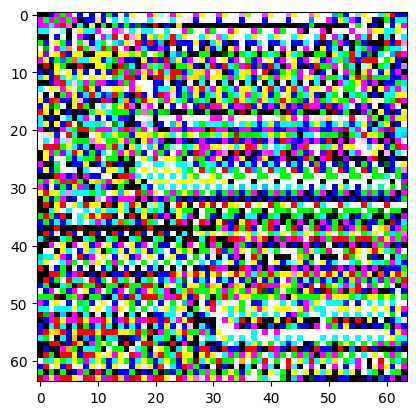

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


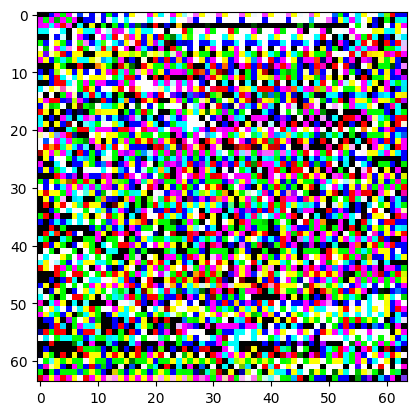

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


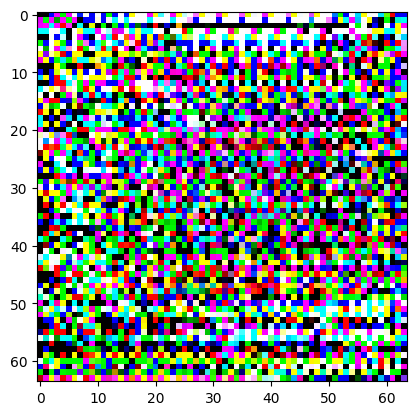

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


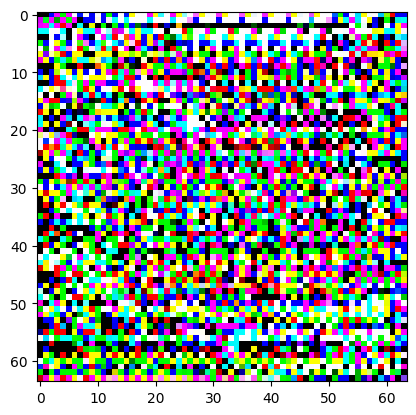

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


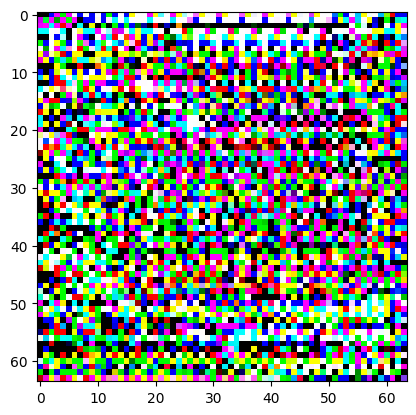

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


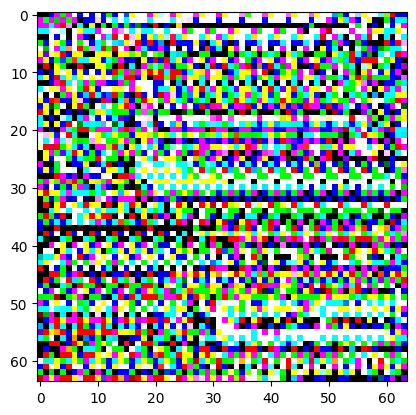

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


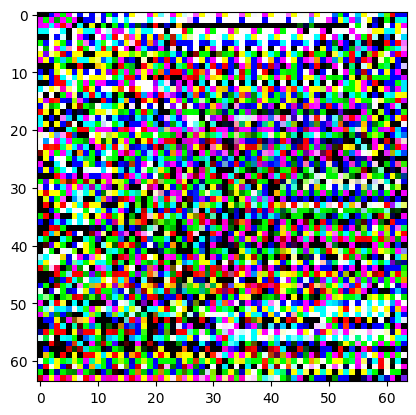

In [156]:
j = 0
for music, image in train_loader:
    if j == 10:
        music = music.to(device)
        image = image.to(device)
        z = torch.randn(music.size(0), 512).to(device)
        fake_image = generator(z, music).permute(0, 2, 3, 1).cpu().detach().numpy()
        for i in range(10):
            plt.imshow(fake_image[i])
            plt.show()
        break
    j += 1